In [ ]:
import os
import cv2
import numpy as np
import splitfolders
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten

In [ ]:
tf.__version__

In [ ]:
os.listdir()

In [ ]:
os.listdir("./dataset/")

In [5]:
with open("./dataset/train.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(" ")
        category = line[-2]
        filename = line[-3]
        
        try:
            if category == "positive":
                os.replace(f"./dataset/train/{filename}", f"./dataset/data/positive/{filename}")
            elif category == "negative":
                os.replace(f"./dataset/train/{filename}", f"./dataset/data/negative/{filename}")
        except FileNotFoundError:
            pass

In [6]:
with open("./dataset/test.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(" ")
        category = line[-2]
        filename = line[-3]
        
        try:
            if category == "positive":
                os.replace(f"./dataset/test/{filename}", f"./dataset/data/positive/{filename}")
            elif category == "negative":
                os.replace(f"./dataset/test/{filename}", f"./dataset/data/negative/{filename}")
        except FileNotFoundError as e:
            pass

In [7]:
if os.path.exists("./dataset/data"):
    os.renames("./dataset/data", "./data")

In [8]:
if not os.path.exists(os.path.join(os.getcwd(), './data_split')):
    splitfolders.ratio("./data", output="./data_split", seed=1337, ratio=(.7, .2, .1), group_prefix=None)

In [10]:
vgg19 = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
vgg19.trainable = False

In [11]:
# Flatten and output layer
flatten_layer = Flatten()
prediction_layer = Dense(2, activation='softmax')

# the final model
model = Sequential([
    vgg19,
    flatten_layer,
    prediction_layer
])

# view the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50178     
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [13]:
# for training data
train_datagen = ImageDataGenerator(
    # rescaling pixel values
    rescale=1./255,
    
    # augmenting the data
    shear_range = 0.2,
    zoom_range = 0.4,
    horizontal_flip = True
)

# for cross validation data
val_datagen = ImageDataGenerator(
    # rescaling pixel values
    rescale=1./255,
)

# obtaining training dataset
training_set = train_datagen.flow_from_directory(
    './data_split/train/',
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical'
)

# obtaining cross-validation dataset
validation_set = val_datagen.flow_from_directory(
    './data_split/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 21617 images belonging to 2 classes.
Found 6176 images belonging to 2 classes.


In [14]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=10,
    batch_size=16,
)

Epoch 1/10
676/676 [==============================] - 1627s 2s/step - loss: 0.3258 - accuracy: 0.8640 - val_loss: 0.2251 - val_accuracy: 0.9092
Epoch 2/10
676/676 [==============================] - 1365s 2s/step - loss: 0.2397 - accuracy: 0.9023 - val_loss: 0.1953 - val_accuracy: 0.9312
Epoch 3/10
676/676 [==============================] - 1228s 2s/step - loss: 0.2501 - accuracy: 0.9014 - val_loss: 0.1793 - val_accuracy: 0.9364
Epoch 4/10
676/676 [==============================] - 1760s 3s/step - loss: 0.2450 - accuracy: 0.9059 - val_loss: 0.2066 - val_accuracy: 0.9197
Epoch 5/10
676/676 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9136

KeyboardInterrupt: 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as m:
    m.write(tflite_model)
    
model.save("model.h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Cross validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Cross validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
from keras.models import load_model

model = load_model("./model.h5")

In [86]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_set = test_datagen.flow_from_directory(
    './data_split/test/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3089 images belonging to 2 classes.


In [87]:
model.evaluate(test_set)

97/97 [==============================] - 78s 805ms/step - loss: 0.2007 - accuracy: 0.9171


[0.2007031887769699, 0.9171252846717834]

In [88]:
y_pred = model.predict(test_set)

In [89]:
y_pred

array([[0.9275548 , 0.07244523],
       [0.18097693, 0.8190231 ],
       [0.7050985 , 0.29490146],
       ...,
       [0.5331548 , 0.4668452 ],
       [0.13775492, 0.8622451 ],
       [0.6795048 , 0.32049513]], dtype=float32)

In [90]:
y_pred[:5]

array([[0.9275548 , 0.07244523],
       [0.18097693, 0.8190231 ],
       [0.7050985 , 0.29490146],
       [0.08164581, 0.91835415],
       [0.17249027, 0.8275097 ]], dtype=float32)

In [91]:
labels_pred = []

for i in range(len(y_pred)):
#     print(np.argmax(y_pred[i]))
    labels_pred.append(np.argmax(y_pred[i]))

In [92]:
labels_pred[:10]

[0, 1, 0, 1, 1, 0, 0, 0, 0, 0]

In [93]:
labels = test_set.labels.tolist()

In [94]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(labels, labels_pred)
print(cf_matrix)

[[1240  180]
 [  76 1593]]


<AxesSubplot:>

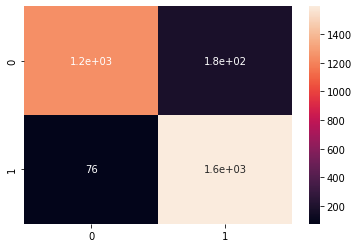

In [95]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

<AxesSubplot:>

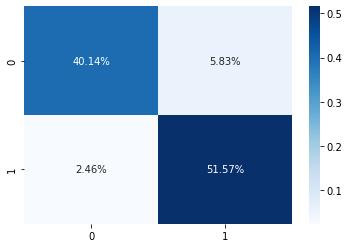

In [96]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot:>

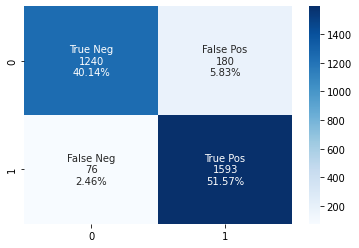

In [97]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [98]:
import cv2

img = cv2.imread("./data_split/test/negative/0a03a65b-9e45-4e3d-ae6c-b8a37112ab31.png")

In [99]:
img = cv2.resize(img, (224, 224))
img = img / 255.

In [100]:
b = model.predict(np.array([img]))

In [101]:
b, np.argmax(b)

(array([[9.9925464e-01, 7.4530486e-04]], dtype=float32), 0)